# Conrady and ACF Dispersion Fit Validation

This notebook imports the refractive index database from Schott and validates the accuracy of two dispersion models:

- **Three-line Conrady fit:** Uses three classic Fraunhofer lines to fit the Conrady equation.
$$ n(\lambda) = A + B/\lambda + C/\lambda^{3.5}$$
- **Seven-line ACF fit:** Uses seven wavelengths to fit a Conrady-like ACF model.
$$ n(\lambda) = A + B/\lambda^{x_1} + C/\lambda^{x_2} + D\lambda^{x_3} $$

The results include accuracy metrics and parameter tables for a selection of common optical glasses.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit, OptimizeWarning

import sys
sys.path.append(str(Path('..').resolve() / 'src'))
from achromatcfw.data.glass_map.schott_glass import glass_sellmeier

import warnings
from IPython.display import display

In [2]:
def get_project_root() -> Path:
    return Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent

root      = get_project_root()
xls_file  = root / "references" / "schott-optical-glass.xlsx"
df        = (pd.read_excel(xls_file, sheet_name="Preferred glasses", engine="openpyxl")
               .rename(columns=str.strip))
df["Glass"] = df["Glass"].str.strip()

# ── wavelength dictionary  |  *visible only* (400‑700 nm) ────────────────
wl_map = {
    # violet
    'nh'     : 404.657,
    'ng'     : 435.835,
    # blue
    "nF'"    : 479.990,
    'nF'     : 486.130,
    # green / yellow
    'ne'     : 546.070,
    'nd'     : 587.560,
    'nD'     : 589.290,
    # orange / red
    'n632.8' : 632.800,
    "nC'"    : 643.846,
    'nC'     : 656.272,
    'nr'     : 706.520,
    # near‑IR
    'ns'     : 852.113,
    'nt'     : 1013.98,
    'n1060.0': 1060.00
}


# ── column lists actually present in the catalogue ───────────────────────
wl_cols     = [c for c in wl_map if c in df.columns]
wl_cols_visible  = [col for col in wl_cols               # 400 ≤ λ ≤ 700 nm
                if 400 <= wl_map[col] <= 700]

print("Columns found: ", wl_cols_visible)

# ── glass selections ─────────────────────────────────────────────────────
all_glasses = df["Glass"].unique().tolist()

common_glasses = [
    "N-BK7", "N-BK10", "N-FK5",
    "N-BAK2", "N-BAK4", "N-LAK22", "N-LAK33B",
    "N-KZFS4", "N-KZFS5",
    "N-SF6", "N-SF10", "N-SF11",
    "N-LASF9", "N-BAF10", "N-LAF21",
    "F2", "N-F2", "SF10", "SF11"
]

# keep only those that actually exist in the sheet
common_glasses = [g for g in common_glasses if g in all_glasses]

if len(common_glasses) < 10:
    print("Preferred list incomplete – falling back to first 10 catalogue entries.")
    common_glasses = all_glasses[:10]

print("common_glasses:", common_glasses)

Columns found:  ['nh', 'ng', "nF'", 'nF', 'ne', 'nd', 'nD', 'n632.8', "nC'", 'nC']
common_glasses: ['N-BK7', 'N-BK10', 'N-FK5', 'N-BAK2', 'N-BAK4', 'N-LAK22', 'N-LAK33B', 'N-KZFS4', 'N-KZFS5', 'N-SF6', 'N-SF10', 'N-SF11', 'N-LASF9', 'N-BAF10', 'N-LAF21', 'F2', 'N-F2', 'SF10', 'SF11']


In [3]:
def conrady(lam_nm, A, B, C):
    lam_nm = np.asarray(lam_nm, float)
    return A + B/lam_nm + C/lam_nm**3.5

def fit_conrady(lam_nm, n, initial=(1.5, 1e3, 1e8)):
    lam_nm, n = map(np.asarray, (lam_nm, n))
    if len(lam_nm) == 3:                      # analytical 3‑point solution
        M = np.column_stack([np.ones_like(lam_nm), 1/lam_nm, 1/lam_nm**3.5])
        return np.linalg.solve(M, n)          # A, B, C
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=OptimizeWarning)
        popt, _ = curve_fit(conrady, lam_nm, n, p0=initial, maxfev=10000)
    return popt                               # A, B, C

def acf(lam_nm, a, b, c, d, x1, x2, x3):
    lam_nm = np.asarray(lam_nm, float)
    return 1 + a + b / lam_nm**x1 + c / lam_nm**x2 + d * lam_nm**x3

def fit_acf(lam_nm, n,
            initial=(0.0, 1e7, 1e12, 1e-12, 3.1, 7, 0.3),
            bounds=((-np.inf,     0,     0, -np.inf,   3.09999999, 6.99999999, 0.29999999),
                    ( np.inf,  1e10,  1e15,  np.inf,   3.10000001, 7.00000001, 0.30000001))):
    """Least‑squares fit of all 7 ACF parameters."""
    lam_nm, n = map(np.asarray, (lam_nm, n))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=OptimizeWarning)
        popt, _ = curve_fit(acf, lam_nm, n, p0=initial,
                            bounds=bounds, maxfev=40000)
    return popt   # a, b, c, d, x1, x2, x3

def rmse(y, yhat): return np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat))**2))

In [4]:
# ── 1 · Define columns & wavelengths used for each purpose ───────────────
fit_cols   = ["nF", "nd", "nC"]                    # three classic lines
fit_lambda = [wl_map[c] for c in fit_cols]         # → [486.13, 587.56, 656.272]

eval_cols  = wl_cols_visible                           # all visible‑band columns
eval_lambda = [wl_map[c] for c in eval_cols]

print("   λ used for 3‑param fit:", [wl_map[c] for c in fit_cols])
print("   λ used for RMS eval  :", [wl_map[c] for c in eval_cols])

# ── 2 · Run the fits & build the table ───────────────────────────────────
results_conrady = []

for glass in common_glasses:
    row = df.loc[df["Glass"] == glass].iloc[0]

    lam_all = np.array(eval_lambda, float)
    n_all   = np.array([row[c] for c in eval_cols], float)

    # --- 3‑line fit -------------------------------------------------------
    n_fdc = row[fit_cols].to_numpy(float)
    A3, B3, C3 = fit_conrady(fit_lambda, n_fdc)

    # --- full least‑squares fit ------------------------------------------
    Af, Bf, Cf = fit_conrady(lam_all, n_all)

    n_pred_3   = conrady(lam_all, A3, B3, C3)
    n_pred_all = conrady(lam_all, Af, Bf, Cf)

    results_conrady.append(dict(
        Glass=glass,
        num_lines=len(lam_all),
        pts_3_RMS = rmse(n_all, n_pred_3),
        pts_3_max = np.max(np.abs(n_all - n_pred_3)),
        full_RMS  = rmse(n_all, n_pred_all),
        full_max  = np.max(np.abs(n_all - n_pred_all)),
        A=A3, B=B3, C=C3
    ))

# --- 3 · Display with 1‑based counter ------------------------------------
summary = pd.DataFrame(results_conrady).sort_values("Glass").reset_index(drop=True)
summary.insert(0, "#", summary.index + 1)

styled = (summary[["#", "Glass", "A", "B", "C",
                   "num_lines", "pts_3_RMS", "pts_3_max",
                   "full_RMS", "full_max"]]
          .style.format({
              "A":"{:+.3e}", "B":"{:+.3e}", "C":"{:+.3e}",
              "pts_3_RMS":"{:.1e}", "pts_3_max":"{:.1e}",
              "full_RMS":"{:.1e}", "full_max":"{:.1e}"
          }))

display(styled)

   λ used for 3‑param fit: [486.13, 587.56, 656.272]
   λ used for RMS eval  : [404.657, 435.835, 479.99, 486.13, 546.07, 587.56, 589.29, 632.8, 643.846, 656.272]


,#,Glass,A,B,C,num_lines,pts_3_RMS,pts_3_max,full_RMS,full_max
0,1,F2,+1.586e+00,+1.583e+01,+3.353e+07,10,2.7e-05,8.5e-05,7.0e-06,1.5e-05
1,2,N-BAF10,+1.640e+00,+1.488e+01,+2.447e+07,10,2.1e-05,6.3e-05,4.4e-06,7.8e-06
2,3,N-BAK2,+1.519e+00,+1.059e+01,+1.321e+07,10,2.7e-05,8.2e-05,6.1e-06,1.0e-05
3,4,N-BAK4,+1.546e+00,+1.166e+01,+1.537e+07,10,1.9e-05,5.9e-05,5.5e-06,1.2e-05
4,5,N-BK10,+1.480e+00,+9.582e+00,+9.077e+06,10,5.2e-06,1.5e-05,2.3e-06,3.8e-06
5,6,N-BK7,+1.497e+00,+1.011e+01,+1.040e+07,10,8.5e-06,2.3e-05,2.5e-06,5.9e-06
6,7,N-F2,+1.587e+00,+1.554e+01,+3.402e+07,10,8.6e-05,2.6e-04,2.0e-05,3.8e-05
7,8,N-FK5,+1.471e+00,+8.930e+00,+8.406e+06,10,5.8e-06,1.6e-05,2.6e-06,5.8e-06
8,9,N-KZFS4,+1.583e+00,+1.493e+01,+2.267e+07,10,3.7e-06,9.7e-06,1.9e-06,4.1e-06
9,10,N-KZFS5,+1.620e+00,+1.665e+01,+2.961e+07,10,2.0e-05,6.0e-05,4.9e-06,8.4e-06


In [5]:
# ── 7 fixed wavelengths covering 404‑1060 nm ─────────────────────────────
fit_cols   = ["nh", "ng", "nF", "ne", "nC", "ns", "n1060.0"]
fit_lambda = [wl_map[c] for c in fit_cols]

# columns available in catalogue for 400‑1100 nm evaluation
wl_cols_eval = [c for c in wl_map if c in df.columns and 400 <= wl_map[c] <= 1100]

print("   λ used for 7‑param fit:", dict(zip(fit_cols, fit_lambda)))
print("   λ used for RMS eval  :", [wl_map[c] for c in wl_cols_eval])

# ── perform the ACF fits --------------------------------------------------
results_acf = []

for glass in common_glasses:
    row = df.loc[df["Glass"] == glass].iloc[0]

    # --- 7‑point fit set --------------------------------------------------
    if row[fit_cols].isna().any():
        missing = list(row[fit_cols][row[fit_cols].isna()].index)
        print(f"Skipping {glass}: missing {missing} data.")
        continue

    lam_fit = np.array(fit_lambda, float)
    n_fit   = row[fit_cols].to_numpy(float)

    # --- evaluation set (all 400‑1100 nm lines present) ------------------
    lam_eval = np.array([wl_map[c] for c in wl_cols_eval if not np.isnan(row[c])], float)
    n_eval   = np.array([row[c]    for c in wl_cols_eval if not np.isnan(row[c])], float)

    # fit 7 parameters
    a, b, c, d, x1, x2, x3 = fit_acf(lam_fit, n_fit)
    n_pred = acf(lam_eval, a, b, c, d, x1, x2, x3)

    results_acf.append(dict(
        Glass=glass,
        a=a, b=b, c=c, d=d, x1=x1, x2=x2, x3=x3,
        num_lines=len(lam_eval),
        ACF_RMS = rmse(n_eval, n_pred),
        ACF_max = np.max(np.abs(n_eval - n_pred))
    ))

# ── table with 1‑based counter ------------------------------------------
summary_acf = pd.DataFrame(results_acf).sort_values("Glass").reset_index(drop=True)
summary_acf.insert(0, "#", summary_acf.index + 1)

styled = (summary_acf[["#", "Glass", "a", "b", "c", "d",
                       "x1", "x2", "x3",
                       "num_lines", "ACF_RMS", "ACF_max"]]
          .style.format({
              "a":"{:+.3e}", "b":"{:+.3e}", "c":"{:+.3e}", "d":"{:+.3e}",
              "x1":"{:.3f}", "x2":"{:.3f}", "x3":"{:.3f}",
              "ACF_RMS":"{:.2e}", "ACF_max":"{:.2e}"
          }))

display(styled)

   λ used for 7‑param fit: {'nh': 404.657, 'ng': 435.835, 'nF': 486.13, 'ne': 546.07, 'nC': 656.272, 'ns': 852.113, 'n1060.0': 1060.0}
   λ used for RMS eval  : [404.657, 435.835, 479.99, 486.13, 546.07, 587.56, 589.29, 632.8, 643.846, 656.272, 706.52, 852.113, 1013.98, 1060.0]


,#,Glass,a,b,c,d,x1,x2,x3,num_lines,ACF_RMS,ACF_max
0,1,F2,+6.498e-01,+4.627e+06,+3.317e+09,-6.182e-03,3.100,7.000,0.300,14,8.02e-05,1.31e-04
1,2,N-BAF10,+7.034e-01,+3.585e+06,+1.192e+06,-6.306e-03,3.100,7.000,0.300,14,9.90e-05,1.60e-04
2,3,N-BAK2,+5.669e-01,+2.102e+06,+1.593e+07,-4.782e-03,3.100,7.000,0.300,14,7.68e-05,1.20e-04
3,4,N-BAK4,+5.976e-01,+2.411e+06,+1.956e+08,-5.168e-03,3.100,7.000,0.300,14,8.05e-05,1.27e-04
4,5,N-BK10,+5.255e-01,+1.583e+06,+2.588e+08,-4.685e-03,3.100,7.000,0.300,14,4.59e-05,6.33e-05
5,6,N-BK7,+5.448e-01,+1.767e+06,+1.332e+08,-4.811e-03,3.100,7.000,0.300,14,5.32e-05,7.87e-05
6,7,N-F2,+6.505e-01,+4.642e+06,+2.600e+08,-6.288e-03,3.100,7.000,0.300,14,3.15e-05,6.07e-05
7,8,N-FK5,+5.136e-01,+1.464e+06,+6.585e+09,-4.413e-03,3.100,7.000,0.300,14,4.14e-05,5.85e-05
8,9,N-KZFS4,+6.493e-01,+3.383e+06,+6.803e+09,-6.608e-03,3.100,7.000,0.300,14,7.70e-05,1.19e-04
9,10,N-KZFS5,+6.902e-01,+4.255e+06,+5.062e+06,-6.966e-03,3.100,7.000,0.300,14,7.91e-05,1.26e-04


In [11]:
EXP1, EXP2, EXP3 = 3.1, 7.0, 0.3

lam_nm = np.linspace(400, 1000, 30)
lam_um = lam_nm / 1000.0         # µm

rows = []

for _, row in summary_acf.iterrows():
    glass = row["Glass"]
    a, b, c, d = row["a"], row["b"], row["c"], row["d"]

    n_acf = 1 + a + b / lam_nm**EXP1 + c / lam_nm**EXP2 + d * lam_nm**EXP3

    p = glass_sellmeier.get(glass)
    if p is None:
        continue
    n2 = 1 + (
        p["b1"] * lam_um**2 / (lam_um**2 - p["c1"]) +
        p["b2"] * lam_um**2 / (lam_um**2 - p["c2"]) +
        p["b3"] * lam_um**2 / (lam_um**2 - p["c3"])
    )
    n_sell = np.sqrt(n2)

    rows.append(dict(
        Glass=glass,
        RMS_error = rmse(n_sell, n_acf),
        Max_error = np.max(np.abs(n_sell - n_acf)),
    ))

df_cmp = pd.DataFrame(rows).sort_values("Glass").reset_index(drop=True)
df_cmp.insert(0, "#", df_cmp.index + 1)

display(df_cmp)

,#,Glass,RMS_error,Max_error
0,1,F2,0.000098,0.000157
1,2,N-BAF10,0.000108,0.000166
2,3,N-BAK2,0.000080,0.000124
3,4,N-BAK4,0.000084,0.000128
4,5,N-BK10,0.000042,0.000075
5,6,N-BK7,0.000051,0.000089
6,7,N-F2,0.000041,0.000067
7,8,N-FK5,0.000039,0.000070
8,9,N-KZFS4,0.000081,0.000126
9,10,N-KZFS5,0.000090,0.000142


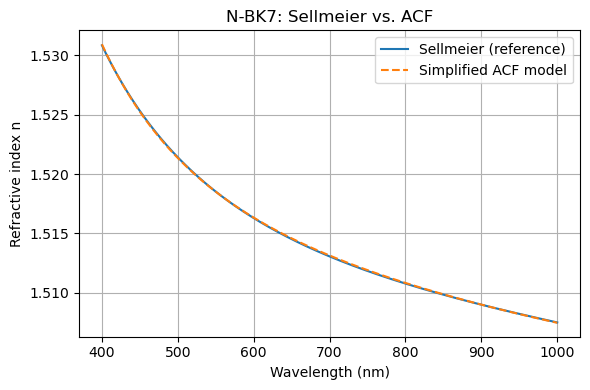

In [12]:
# -------- choose a glass -------------------------------------------------
glass = "N-BK7"

# -------- pull coefficients ---------------------------------------------
row = summary_acf.loc[summary_acf["Glass"] == glass].iloc[0]
a, b, c, d = row["a"], row["b"], row["c"], row["d"]

p = glass_sellmeier[glass]

# -------- wavelength grid ------------------------------------------------
lam_nm = np.linspace(400, 1000, 601)
lam_um = lam_nm / 1000.0

# -------- models ---------------------------------------------------------
n2_sell = 1 + (
    p["b1"] * lam_um**2 / (lam_um**2 - p["c1"]) +
    p["b2"] * lam_um**2 / (lam_um**2 - p["c2"]) +
    p["b3"] * lam_um**2 / (lam_um**2 - p["c3"])
)
n_sell = np.sqrt(n2_sell)

EXP1, EXP2, EXP3 = 3.1, 7.0, 0.3
n_acf = 1 + a + b / lam_nm**EXP1 + c / lam_nm**EXP2 + d * lam_nm**EXP3

# -------- plot -----------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(lam_nm, n_sell, label="Sellmeier (reference)")
plt.plot(lam_nm, n_acf, linestyle="--", label="Simplified ACF model")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Refractive index n")
plt.title(f"{glass}: Sellmeier vs. ACF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()